In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy.ndimage as ndimage
import pymannkendall as mk


In [2]:
# importing data
# numpy array with columns of date/time and num_value

PC_0192_details = pd.read_csv("Details_PC-0192.csv", sep=',')
# dtype='str', comments="#", delimiter="\t", unpack=False)
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,10/01/2017 18:00,1,1,28/12/2016 18:00,5,11/01/2017 14:00,FLAMI


In [3]:
# changing required fields to correct datetime data type to avoid string issues

PC_0192_details['failed_extubation_deid_date'] = pd.to_datetime(PC_0192_details['failed_extubation_deid_date'], format='%d/%m/%Y %H:%M')
PC_0192_details['re_intubation_deid_date'] = pd.to_datetime(PC_0192_details['re_intubation_deid_date'], format='%d/%m/%Y %H:%M')

In [4]:
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,2017-01-10 18:00:00,1,1,28/12/2016 18:00,5,2017-01-11 14:00:00,FLAMI


In [5]:
failed_extubation = PC_0192_details.iloc[0,8]
re_intubation = PC_0192_details.iloc[0,13]

print(failed_extubation, re_intubation)

2017-01-10 18:00:00 2017-01-11 14:00:00


In [6]:
# creating df for the time series data

PC_0192_data = pd.read_csv("PC0192_1_HR.csv", sep=',')
PC_0192_data

,monitor,record_date_time,num_value
0,HR,2016-12-22 12:09:21,98
1,HR,2016-12-22 12:09:26,98
2,HR,2016-12-22 12:09:31,98
3,HR,2016-12-22 12:09:36,96
4,HR,2016-12-22 12:09:41,97
...,...,...,...
942176,HR,2017-02-18 17:08:34,96
942177,HR,2017-02-18 17:08:39,96
942178,HR,2017-02-18 17:08:44,95
942179,HR,2017-02-18 17:08:49,96


In [7]:
# making sure 'record_date_time' is of the correct type

# PC_0192_data['record_date_time'] = PC_0192_data['record_date_time'].dt.strftime('%d/%m/%Y %H:%M:%S')
PC_0192_data['record_date_time'] = pd.to_datetime(PC_0192_data['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_data

,monitor,record_date_time,num_value
0,HR,2016-12-22 12:09:21,98
1,HR,2016-12-22 12:09:26,98
2,HR,2016-12-22 12:09:31,98
3,HR,2016-12-22 12:09:36,96
4,HR,2016-12-22 12:09:41,97
...,...,...,...
942176,HR,2017-02-18 17:08:34,96
942177,HR,2017-02-18 17:08:39,96
942178,HR,2017-02-18 17:08:44,95
942179,HR,2017-02-18 17:08:49,96


In [8]:
# 'failed_extubation' and 're_intubation' are formatted differently to 'PC_0192_data'
# change manually for now, BUT COME BACK TO THIS AND CHANGE PROPERLY

# failed_extubation_2 = '2017-01-10 18:00:00'
# re_intubation_2 = '2017-01-11 14:00:00'

# fixed this

In [9]:
# PC_0192_data.timestamp.searchsorted(failed_extubation)

In [10]:
# dt='2022-02-07T23:18:06.08349'
# PC_0192_data. timestamp.searchsorted(dt)

In [11]:
# np.where(PC_0192_data["record_date_time"] == test)[0]

In [12]:
# failed_extubation = pd.to_datetime(failed_extubation)
# s = PC_0192_data['record_date_time'].loc[PC_0192_data['record_date_time'].index.unique()[PC_0192_data['record_date_time'].index.unique().get_loc(failed_extubation, method='nearest')]]

In [13]:
# finding indexes at which failed_extubation and re_intubation would need to be inserted to maintain order

failed_extubation_index = PC_0192_data.record_date_time.searchsorted(failed_extubation)
re_intubation_index = PC_0192_data.record_date_time.searchsorted(re_intubation)

print(failed_extubation_index, re_intubation_index)

320515 334633


In [14]:
# lifting data for the time peried where patient was extubated

PC_0192_extubated = PC_0192_data.iloc[failed_extubation_index+1:re_intubation_index-1, :]
PC_0192_extubated

,monitor,record_date_time,num_value
320516,HR,2017-01-10 18:00:06,100
320517,HR,2017-01-10 18:00:11,100
320518,HR,2017-01-10 18:00:16,100
320519,HR,2017-01-10 18:00:21,100
320520,HR,2017-01-10 18:00:26,99
...,...,...,...
334627,HR,2017-01-11 13:59:32,121
334628,HR,2017-01-11 13:59:36,121
334629,HR,2017-01-11 13:59:42,121
334630,HR,2017-01-11 13:59:46,121


<AxesSubplot:xlabel='record_date_time'>

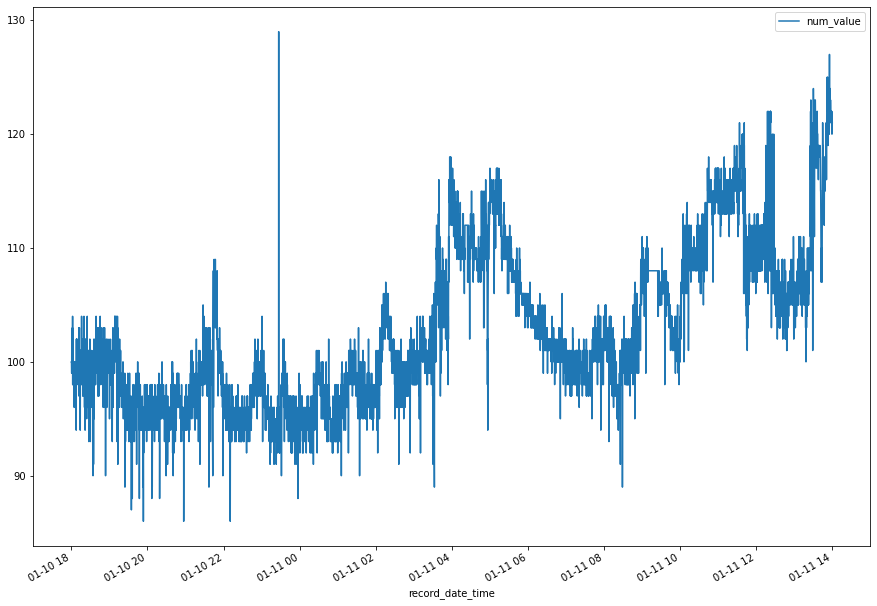

In [15]:
PC_0192_extubated.plot('record_date_time', 'num_value', figsize=(15, 11))

- anomalous point just before 01-11 00:00?
- leave as is for now

In [16]:
# use timedelta to add a period of time to a timestamp:

PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10)
PC_0192_extubated['record_date_time'].iloc[-1]

Timestamp('2017-01-11 13:59:52')

### Rolling mean:

In [17]:
# following has incorrect timestamps

# k = 0

# PC_0192_mean = pd.DataFrame(columns=['start_time','end_time','mean'])

# while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

#     index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
#     index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

#     mean = PC_0192_extubated['num_value'][index_1:index_2].mean(axis=0)

#     PC_0192_mean = PC_0192_mean.append({'start_time': PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k),
#     'end_time':PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k), 'mean':mean}, ignore_index=True)
#     k += 1


In [18]:
k = 0

PC_0192_mean = pd.DataFrame(columns=['start_time','end_time','mean'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

    mean = PC_0192_extubated['num_value'][index_1:index_2].mean(axis=0)

    PC_0192_mean = PC_0192_mean.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
    k += 1

In [19]:
PC_0192_extubated['record_date_time'].iloc[index_1]

Timestamp('2017-01-11 13:49:07')

In [20]:
PC_0192_mean

,start_time,end_time,mean
0,2017-01-10 18:00:06,2017-01-10 18:10:06,99.521008
1,2017-01-10 18:01:06,2017-01-10 18:11:06,99.487395
2,2017-01-10 18:02:11,2017-01-10 18:12:06,99.344538
3,2017-01-10 18:03:06,2017-01-10 18:13:06,99.383333
4,2017-01-10 18:04:06,2017-01-10 18:14:06,99.4
...,...,...,...
1185,2017-01-11 13:45:07,2017-01-11 13:55:07,119.408333
1186,2017-01-11 13:46:07,2017-01-11 13:56:06,119.916667
1187,2017-01-11 13:47:07,2017-01-11 13:57:06,120.483333
1188,2017-01-11 13:48:07,2017-01-11 13:58:07,121.075


In [21]:
# PC_0192_mean.plot(x='start_time', y='mean')

# TypeError: no numeric data to plot

In [22]:
index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=540+k))

mean = PC_0192_extubated['num_value'][index_1:index_2].mean()
mean

121.98305084745763

In [23]:
PC_0192_mean.dtypes

start_time    datetime64[ns]
end_time      datetime64[ns]
mean                  object
dtype: object

In [24]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

In [25]:
PC_0192_mean.iloc[910]

start_time    2017-01-11 09:24:32
end_time      2017-01-11 09:24:32
mean                          NaT
Name: 910, dtype: object

In [26]:
# PC_0192_mean = PC_0192_mean.drop(910)

In [27]:
# PC_0192_mean.plot(x='start_time', y='mean')

In [28]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

In [29]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_mean['mean']):
    if pd.isnull(row):
        PC_0192_mean = PC_0192_mean.drop(i)

In [30]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

The correlation coefficient of the mean is 1.0 which is strong positive.


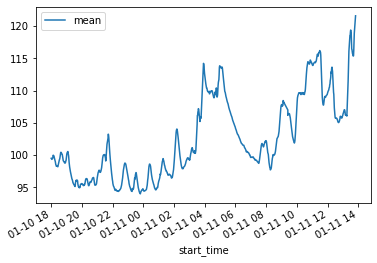

In [31]:
PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

PC_0192_mean.plot(x='start_time', y='mean')

print(f"The correlation coefficient of the mean is {PC_0192_mean.corr()['mean'][0]} which is strong positive.")

don't really understand significance of increasing mean COME BACK TO THIS!

### Rolling variance (intervals of 10 mins):

In [32]:
k = 0

PC_0192_var_10_min = pd.DataFrame(columns=['start_time','end_time','variance'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

    var = PC_0192_extubated['num_value'][index_1:index_2].var(axis=0)

    PC_0192_var_10_min = PC_0192_var_10_min.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
    k += 1


In [33]:
PC_0192_var_10_min

,start_time,end_time,variance
0,2017-01-10 18:00:06,2017-01-10 18:10:06,1.963538
1,2017-01-10 18:01:06,2017-01-10 18:11:06,1.963823
2,2017-01-10 18:02:11,2017-01-10 18:12:06,1.685372
3,2017-01-10 18:03:06,2017-01-10 18:13:06,1.683754
4,2017-01-10 18:04:06,2017-01-10 18:14:06,1.939496
...,...,...,...
1185,2017-01-11 13:45:07,2017-01-11 13:55:07,9.520938
1186,2017-01-11 13:46:07,2017-01-11 13:56:06,10.497199
1187,2017-01-11 13:47:07,2017-01-11 13:57:06,10.503922
1188,2017-01-11 13:48:07,2017-01-11 13:58:07,8.053151


In [34]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_var_10_min['variance']):
    if pd.isnull(row):
        PC_0192_var_10_min = PC_0192_var_10_min.drop(i)

<AxesSubplot:xlabel='start_time'>

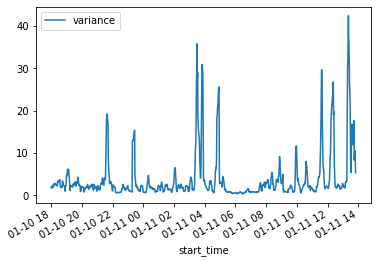

In [35]:
PC_0192_var_10_min['variance'] = pd.to_numeric(PC_0192_var_10_min['variance'])

PC_0192_var_10_min.plot(x='start_time', y='variance')

rough notes:

- patches of low variance throughout
- but we generally see higher variances closer to the critical point (lower resilience)
- this suggests the critical slowing down begins quite early on, in this case variance gets relatively high about 11 hours before critical point

### Rolling variance (intervals of 1 hour):

In [36]:
k = 0

PC_0192_var_1_hour = pd.DataFrame(columns=['start_time','end_time','variance'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k))

    var = PC_0192_extubated['num_value'][index_1:index_2].var(axis=0)

    PC_0192_var_1_hour = PC_0192_var_1_hour.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
    k += 1

In [37]:
PC_0192_var_1_hour

,start_time,end_time,variance
0,2017-01-10 18:00:06,2017-01-10 19:00:10,2.794764
1,2017-01-10 18:01:06,2017-01-10 19:01:10,2.812136
2,2017-01-10 18:02:11,2017-01-10 19:02:10,2.756124
3,2017-01-10 18:03:06,2017-01-10 19:03:10,2.717823
4,2017-01-10 18:04:06,2017-01-10 19:04:10,2.724989
...,...,...,...
1135,2017-01-11 12:55:08,2017-01-11 13:55:07,43.828784
1136,2017-01-11 12:56:08,2017-01-11 13:56:06,45.213919
1137,2017-01-11 12:57:08,2017-01-11 13:57:06,46.413874
1138,2017-01-11 12:58:08,2017-01-11 13:58:07,46.996571


In [38]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_var_1_hour['variance']):
    if pd.isnull(row):
        PC_0192_var_1_hour = PC_0192_var_1_hour.drop(i)

The correlation coefficient of the variance is 1.0 which is strong positive.


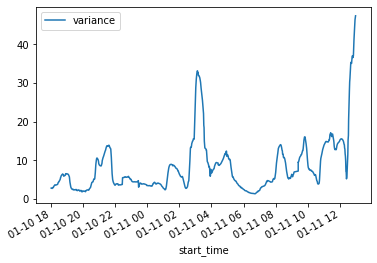

In [39]:
PC_0192_var_1_hour['variance'] = pd.to_numeric(PC_0192_var_1_hour['variance'])

PC_0192_var_1_hour.plot(x='start_time', y='variance')

print(f"The correlation coefficient of the variance is {PC_0192_var_1_hour.corr()['variance'][0]} which is strong positive.")

### Autocorrelation:

In [40]:
idx1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0])
idx2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=20))

idx3 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[-1] - timedelta(minutes=20))
idx4 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[-1])


# pd.plotting.lag_plot(PC_0192_extubated['num_value'][idx1:idx2], lag=1)
# print(f"Autocorrelation for first 20 mins: {PC_0192_extubated['num_value'][idx1:idx2].autocorr()}")

Autocorrelation for first 20 mins: 0.44161008980408856


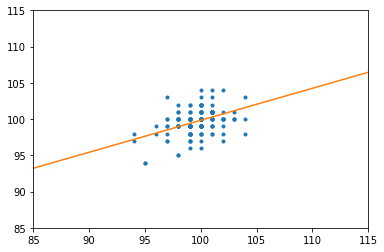

In [41]:
plt.plot(PC_0192_extubated['num_value'][idx1:idx2], PC_0192_extubated['num_value'][idx1+1:idx2+1], '.')

theta = np.polyfit(PC_0192_extubated['num_value'][idx1:idx2], PC_0192_extubated['num_value'][idx1+1:idx2+1], 1)
line_of_best_fit1 = theta[1] + theta[0] * np.linspace(85,115,400)

plt.plot(np.linspace(85,115,400), line_of_best_fit1)

plt.xlim(xmin=85,xmax=115)
plt.ylim(ymin=85,ymax=115)

print(f"Autocorrelation for first 20 mins: {PC_0192_extubated['num_value'][idx1:idx2].autocorr()}")

Autocorrelation for final 20 mins: 0.9700082051791865


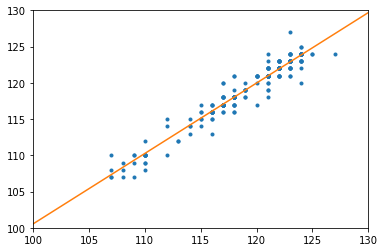

In [42]:
plt.plot(PC_0192_extubated['num_value'][idx3-1:idx4-1], PC_0192_extubated['num_value'][idx3:idx4], '.')

theta = np.polyfit(PC_0192_extubated['num_value'][idx3-1:idx4-1], PC_0192_extubated['num_value'][idx3:idx4], 1)
line_of_best_fit2 = theta[1] + theta[0] * np.linspace(100,130,400)

plt.plot(np.linspace(100,130,400), line_of_best_fit2)

plt.xlim(xmin=100,xmax=130)
plt.ylim(ymin=100,ymax=130)

print(f"Autocorrelation for final 20 mins: {PC_0192_extubated['num_value'][idx3:idx4].autocorr()}")

results as expected!
(10 mins looked like too few data points so used the initial and finial 20 mins to data points)

In [43]:
k = 0

PC_0192_ac_1_hour = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k))

    ac = PC_0192_extubated['num_value'][index_1:index_2].autocorr()

    PC_0192_ac_1_hour = PC_0192_ac_1_hour.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
    k += 1

In [44]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_ac_1_hour['autocorrelation']):
    if pd.isnull(row):
        PC_0192_ac_1_hour = PC_0192_ac_1_hour.drop(i)

The correlation coefficient of the autocorrelation is 1.0 which is strong positive.


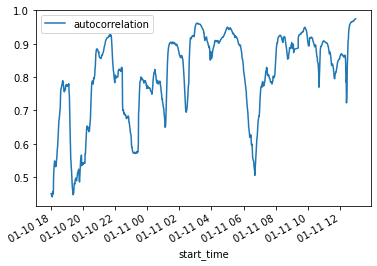

In [45]:
PC_0192_ac_1_hour['autocorrelation'] = pd.to_numeric(PC_0192_ac_1_hour['autocorrelation'])

PC_0192_ac_1_hour.plot(x='start_time', y='autocorrelation')

# theta = np.polyfit(enumerate(PC_0192_ac_1_hour['autocorrelation'])[0], enumerate(PC_0192_ac_1_hour['autocorrelation'])[1], 1)
# line_of_best_fit2 = theta[1] + theta[0] * np.linspace(1,100,400)

# plt.plot(np.linspace(1,100,400), line_of_best_fit2)

print(f"The correlation coefficient of the autocorrelation is {PC_0192_ac_1_hour.corr()['autocorrelation'][0]} which is strong positive.")

general upwards trend?

### Making this into a function:

In [106]:
def rolling_mean(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    global df
    global p

    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','mean'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        mean = data['num_value'][index_1:index_2].mean()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['mean']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['mean'] = pd.to_numeric(df['mean'])

    df.plot(x='start_time', y='mean', figsize=(10,8))

    p = mk.hamed_rao_modification_test(df['mean'])[2]

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['mean'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['mean'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['mean'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['mean'])}")


The kendall tau correlation coefficient of the autocorrelation is 0.6079577215638184, and the p-value is 1.1709956691104076e-196.
The Hamid and Rao correction relusts in a p-value of 1.0428550778485146e-07
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=1.0428550778485146e-07, z=5.319093548282201, Tau=0.6080561562489273, s=354290.0, var_s=4436495855.792175, slope=0.013871106247873128, intercept=93.47621291154074)


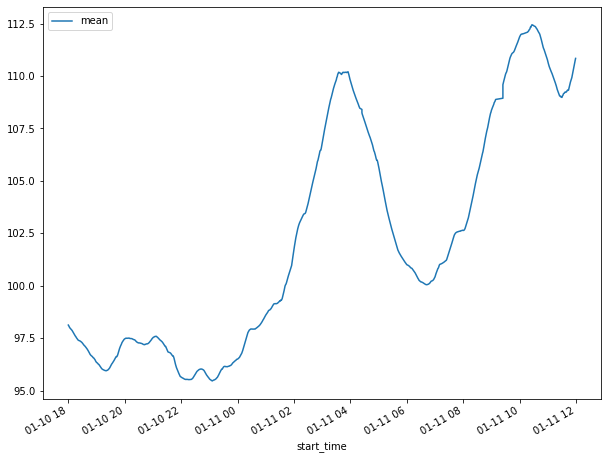

In [47]:
rolling_mean(PC_0192_extubated, 120)

increasing mean could be known expected i.e: heart rate goes up before the critical point

In [107]:
def rolling_variance(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'variance'
    time - size of window in minutes
    """
    global df
    global p
    
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','variance'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        var = data['num_value'][index_1:index_2].var()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['variance']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['variance'] = pd.to_numeric(df['variance'])

    df.plot(x='start_time', y='variance', figsize=(10,8))

    p = mk.hamed_rao_modification_test(df['variance'])[2]

    print(f"The kendall tau correlation coefficient of the variance is {stats.kendalltau(df['start_time'], df['variance'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['variance'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['variance'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['variance'])}")

        

The kendall tau correlation coefficient of the variance is 0.3668529583600319, and the p-value is 7.463802251160827e-73.
The Hamid and Rao correction relusts in a p-value of 5.7088586030040744e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=5.7088586030040744e-05, z=4.024532599255757, Tau=0.3670047712216387, s=213839.0, var_s=2823181949.082718, slope=0.011269249843240403, intercept=3.1459322236633405)


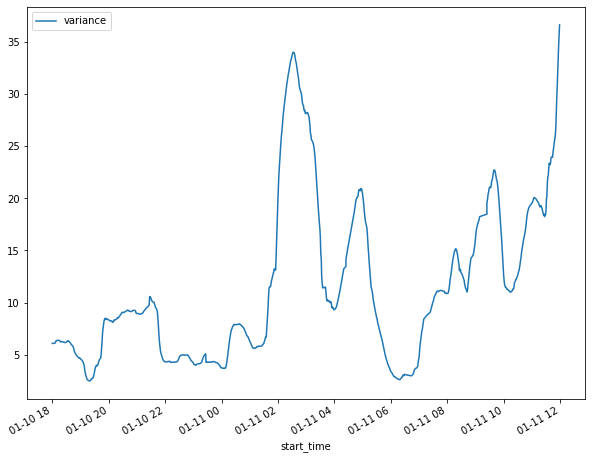

In [49]:
rolling_variance(PC_0192_extubated, 120)

In [108]:
def rolling_autocorrelation(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    global df
    global p
    
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    p = mk.hamed_rao_modification_test(df['autocorrelation'])[2]

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")


The kendall tau correlation coefficient of the autocorrelation is 0.3726970886514456, and the p-value is 3.919415888662201e-75.
The Hamid and Rao correction relusts in a p-value of 0.0022192376840606265
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0022192376840606265, z=3.059206976844212, Tau=0.3728040366594583, s=217218.0, var_s=5041617584.0123, slope=0.00014225044605823496, intercept=0.8162803131854764)


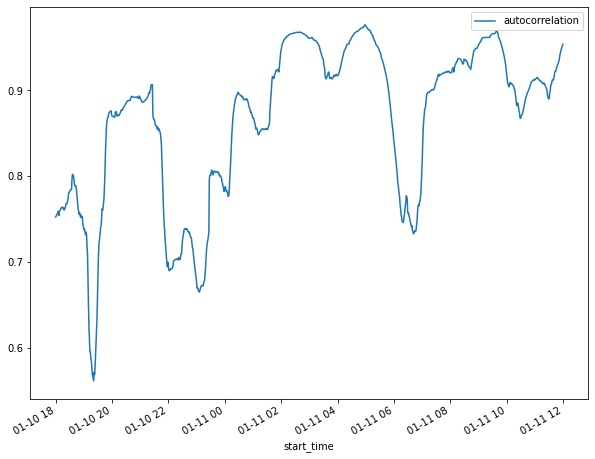

In [51]:
rolling_autocorrelation(PC_0192_extubated, 120)

In [52]:
# result = mk.hamed_rao_modification_test(data)
# print(result)

### Gaussian smoothing

https://towardsdatascience.com/gaussian-smoothing-in-time-series-data-c6801f8a4dc3

In [53]:
PC_0192_data_smoothed = PC_0192_data.copy()
PC_0192_data_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_data['num_value'], sigma=100)
print(ndimage.gaussian_filter1d(PC_0192_data['num_value'], 2))

[97 97 97 ... 95 95 95]


In [54]:
PC_0192_extubated_smoothed = PC_0192_data_smoothed.iloc[failed_extubation_index+1:re_intubation_index-1, :]

print(max(PC_0192_extubated['num_value'] - PC_0192_extubated_smoothed['num_value']))

34


The kendall tau correlation coefficient of the autocorrelation is 0.6140470134178728, and the p-value is 1.4928071951129554e-200.
The Hamid and Rao correction relusts in a p-value of 8.927326478058717e-08
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=8.927326478058717e-08, z=5.347305495445583, Tau=0.6141094291696702, s=357817.0, var_s=4477643573.357839, slope=0.014004629629629525, intercept=92.95455035461508)


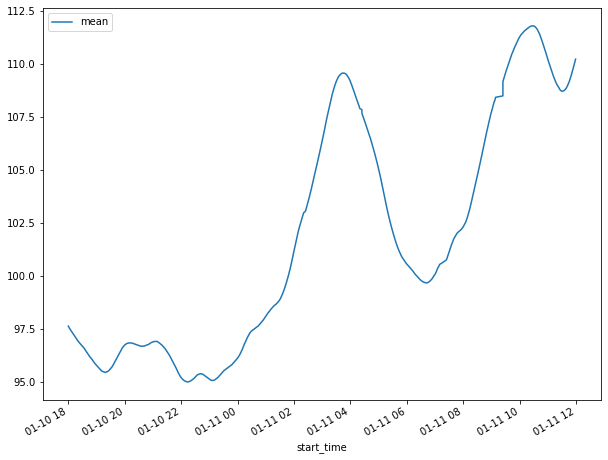

In [55]:
rolling_mean(PC_0192_extubated_smoothed, 120)

The kendall tau correlation coefficient of the variance is 0.35102420661128186, and the p-value is 7.391772632366862e-67.
The Hamid and Rao correction relusts in a p-value of 3.7161044800448906e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=3.7161044800448906e-05, z=4.124456974265389, Tau=0.3511773590086843, s=204617.0, var_s=2461192743.7859116, slope=0.006405334870310377, intercept=0.6060163720266214)


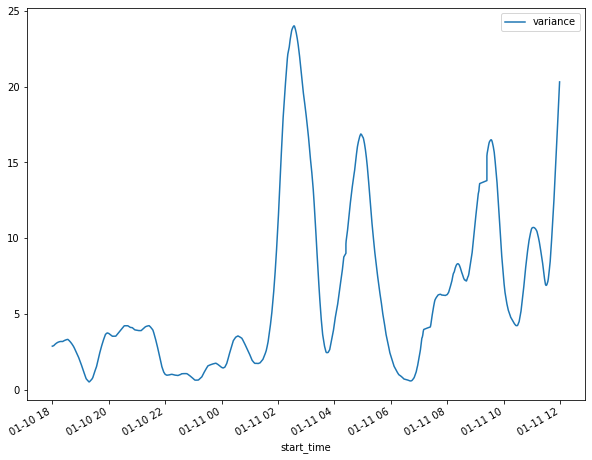

In [56]:
rolling_variance(PC_0192_extubated_smoothed, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.21255121585177755, and the p-value is 1.3254121748073182e-25.
The Hamid and Rao correction relusts in a p-value of 0.019415542180910794
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.019415542180910794, z=2.337454922923418, Tau=0.21269179281227474, s=123927.0, var_s=2810854563.3741407, slope=6.836901389216088e-07, intercept=0.9986270909842048)


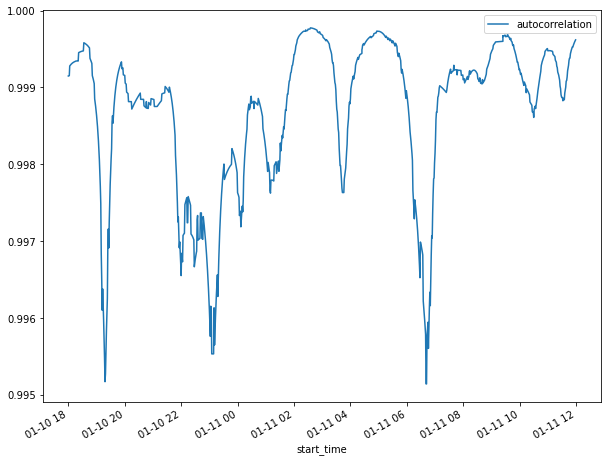

In [57]:
rolling_autocorrelation(PC_0192_extubated_smoothed, 120)

### Finding and analysing residuals

In [58]:
PC_0192_extubated_residuals = PC_0192_extubated.copy()

PC_0192_mean_smoothed = PC_0192_mean.copy()
PC_0192_mean_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_mean['mean'], sigma=100)

PC_0192_extubated_residuals['num_value'] = PC_0192_extubated['num_value'].subtract(PC_0192_mean_smoothed['mean'])

PC_0192_mean_smoothed['mean']

# would need to interpolate/resample using this method so instead smooth the initial time series data

0        99.521008
1        99.487395
2        99.344538
3        99.383333
4        99.400000
           ...    
1185    119.408333
1186    119.916667
1187    120.483333
1188    121.075000
1189    121.600000
Name: mean, Length: 1185, dtype: float64

In [59]:
PC_0192_residuals = PC_0192_extubated.copy()
PC_0192_residuals['num_value'] = PC_0192_extubated['num_value'] - PC_0192_extubated_smoothed['num_value']
PC_0192_residuals


,monitor,record_date_time,num_value
320516,HR,2017-01-10 18:00:06,0
320517,HR,2017-01-10 18:00:11,0
320518,HR,2017-01-10 18:00:16,0
320519,HR,2017-01-10 18:00:21,0
320520,HR,2017-01-10 18:00:26,-1
...,...,...,...
334627,HR,2017-01-11 13:59:32,2
334628,HR,2017-01-11 13:59:36,2
334629,HR,2017-01-11 13:59:42,2
334630,HR,2017-01-11 13:59:46,2


The kendall tau correlation coefficient of the autocorrelation is -0.21059236792832056, and the p-value is 3.7193992774640377e-25.
The Hamid and Rao correction relusts in a p-value of 3.74189396852298e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=3.74189396852298e-05, z=-4.122864767952334, Tau=-0.21063742148079498, s=-122730.0, var_s=886127493.1412896, slope=-9.252962851819613e-05, intercept=0.5452236311319176)


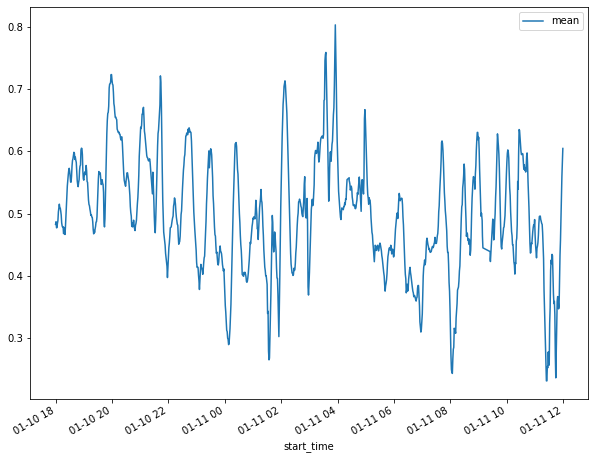

In [60]:
rolling_mean(PC_0192_residuals, 120)

The kendall tau correlation coefficient of the variance is 0.18184377305823615, and the p-value is 3.5984997796377676e-19.
The Hamid and Rao correction relusts in a p-value of 0.11937368577710039
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.11937368577710039, z=1.5574078406734448, Tau=0.1816359454913672, s=105832.0, var_s=4617650787.19442, slope=0.0014059797745702698, intercept=2.396027536513267)


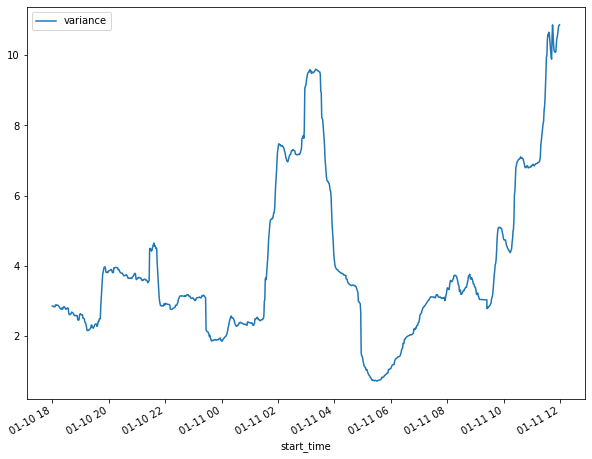

In [61]:
rolling_variance(PC_0192_residuals, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.3334663581924342, and the p-value is 1.6194054706174654e-60.
The Hamid and Rao correction relusts in a p-value of 0.0016303465784941462
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0016303465784941462, z=3.1504222257473793, Tau=0.333250952528061, s=194172.0, var_s=3798666870.8042583, slope=0.0002301023743832364, intercept=0.5960785315181526)


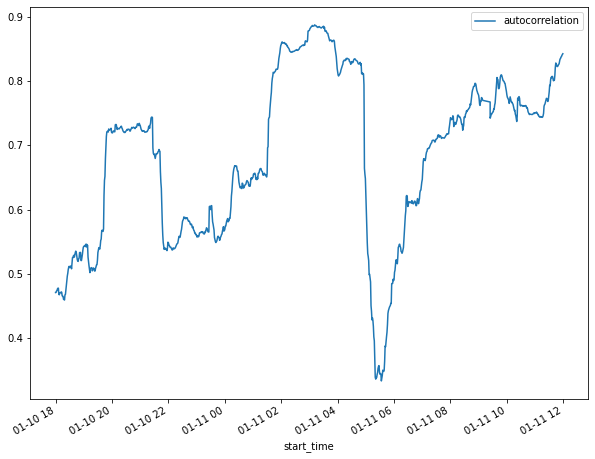

In [62]:
rolling_autocorrelation(PC_0192_residuals, 120)

<AxesSubplot:xlabel='record_date_time'>

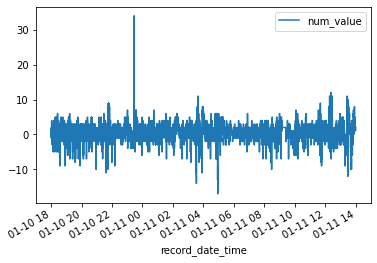

In [63]:
PC_0192_residuals.plot(x='record_date_time', y='num_value')

In [64]:
PC_0192_residuals

,monitor,record_date_time,num_value
320516,HR,2017-01-10 18:00:06,0
320517,HR,2017-01-10 18:00:11,0
320518,HR,2017-01-10 18:00:16,0
320519,HR,2017-01-10 18:00:21,0
320520,HR,2017-01-10 18:00:26,-1
...,...,...,...
334627,HR,2017-01-11 13:59:32,2
334628,HR,2017-01-11 13:59:36,2
334629,HR,2017-01-11 13:59:42,2
334630,HR,2017-01-11 13:59:46,2


smoothed the data using gaussian package for now - come back and do this by averaging over windows!!!

### Removing outliers

In [65]:
mu = PC_0192_extubated_smoothed['num_value'].mean()
sigma = PC_0192_extubated_smoothed['num_value'].std()
mu-3*sigma

83.02933330597907

In [66]:
# replacing values outside of mu+-2sigma with the mean of the values either side

PC_0192_extubated_smoothed_no_anomalies = PC_0192_extubated_smoothed.copy()

# idx = 0

for idx, val in enumerate(PC_0192_extubated_smoothed_no_anomalies['num_value']):
    if not (mu - 3*sigma < val < mu + 3*sigma):
        PC_0192_extubated_smoothed_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_extubated_smoothed['num_value'].iloc[idx+1] + PC_0192_extubated_smoothed['num_value'].iloc[idx-1])


In [67]:
# for val in PC_0192_extubated_smoothed_no_anomalies['num_value']:
#     print(val)

<AxesSubplot:xlabel='record_date_time'>

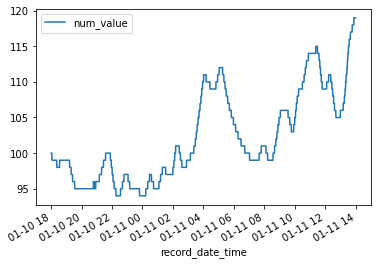

In [68]:
# print(max(PC_0192_extubated_smoothed_no_anomalies['num_value']-PC_0192_extubated_smoothed['num_value']))
PC_0192_extubated_smoothed_no_anomalies.plot(x='record_date_time', y='num_value')

<AxesSubplot:xlabel='record_date_time'>

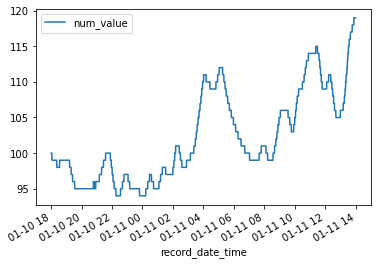

In [69]:
PC_0192_extubated_smoothed.plot(x='record_date_time', y='num_value')

In [70]:
mu_residual = PC_0192_residuals['num_value'].mean()
sigma_residual = PC_0192_residuals['num_value'].std()
mu_residual+3*sigma_residual

6.744413040734652

In [71]:
for idx, val in enumerate(PC_0192_extubated_smoothed_no_anomalies['num_value']):
    print(idx, val)

0 100
1 100
2 100
3 100
4 100
5 100
6 100
7 100
8 100
9 100
10 100
11 100
12 100
13 100
14 100
15 100
16 100
17 100
18 100
19 100
20 100
21 100
22 100
23 100
24 100
25 100
26 100
27 100
28 100
29 100
30 100
31 99
32 99
33 99
34 99
35 99
36 99
37 99
38 99
39 99
40 99
41 99
42 99
43 99
44 99
45 99
46 99
47 99
48 99
49 99
50 99
51 99
52 99
53 99
54 99
55 99
56 99
57 99
58 99
59 99
60 99
61 99
62 99
63 99
64 99
65 99
66 99
67 99
68 99
69 99
70 99
71 99
72 99
73 99
74 99
75 99
76 99
77 99
78 99
79 99
80 99
81 99
82 99
83 99
84 99
85 99
86 99
87 99
88 99
89 99
90 99
91 99
92 99
93 99
94 99
95 99
96 99
97 99
98 99
99 99
100 99
101 99
102 99
103 99
104 99
105 99
106 99
107 99
108 99
109 99
110 99
111 99
112 99
113 99
114 99
115 99
116 99
117 99
118 99
119 99
120 99
121 99
122 99
123 99
124 99
125 99
126 99
127 99
128 99
129 99
130 99
131 99
132 99
133 99
134 99
135 99
136 99
137 99
138 99
139 99
140 99
141 99
142 99
143 99
144 99
145 99
146 99
147 99
148 99
149 99
150 99
151 99
152 99
153 99
1

<AxesSubplot:xlabel='record_date_time'>

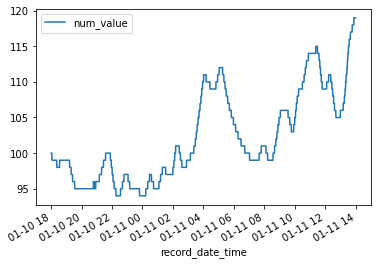

In [72]:
PC_0192_extubated_smoothed.plot(x='record_date_time', y='num_value')

### Removing anomalies from residuals

In [73]:
PC_0192_residuals_no_anomalies = PC_0192_residuals.copy()

# idx = 0

for idx, val in enumerate(PC_0192_residuals_no_anomalies['num_value']):
    if not (mu_residual - 3*sigma_residual < val < mu_residual + 3*sigma_residual):
        if idx == 0:
            PC_0192_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_residuals['num_value'].iloc[idx+1]
        if idx == 14116:
            PC_0192_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_residuals['num_value'].iloc[idx-1]
        else:
            PC_0192_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_residuals['num_value'].iloc[idx+1] + PC_0192_residuals['num_value'].iloc[idx-1])


/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='record_date_time'>

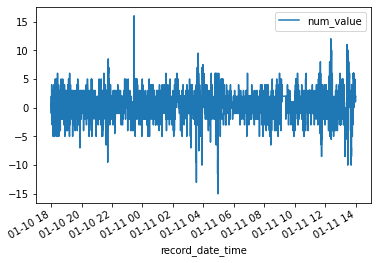

In [74]:
PC_0192_residuals_no_anomalies.plot(x='record_date_time', y='num_value')

The kendall tau correlation coefficient of the autocorrelation is -0.2582963753587517, and the p-value is 5.2512862375533705e-37.
The Hamid and Rao correction relusts in a p-value of 0.00021481448497717714
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=0.00021481448497717714, z=-3.700925569098241, Tau=-0.2583668005354752, s=-150540.0, var_s=1654540307.3321786, slope=-0.00012439775248968888, intercept=0.5791327803916582)


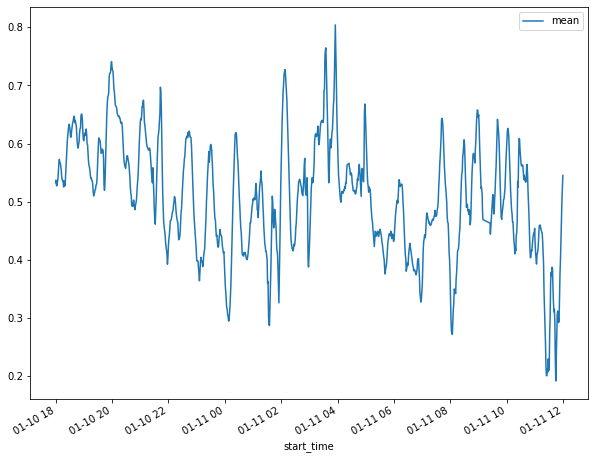

In [75]:
rolling_mean(PC_0192_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the variance is 0.2509644203974201, and the p-value is 4.86360944615869e-35.
The Hamid and Rao correction relusts in a p-value of 0.028063167007476242
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.028063167007476242, z=2.1964022186290384, Tau=0.2507500085813339, s=146102.0, var_s=4424687766.16985, slope=0.0015174255888949224, intercept=2.017579752118987)


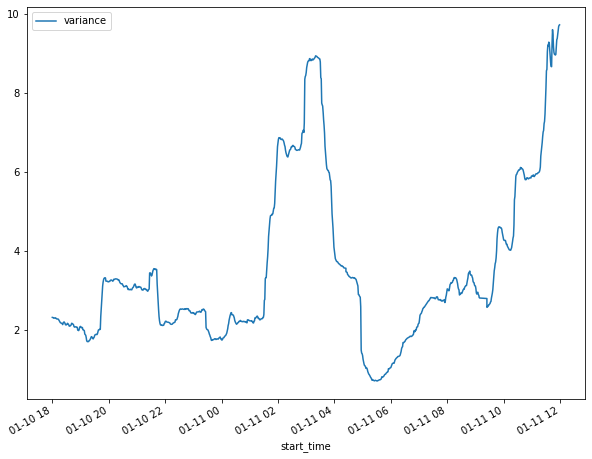

In [76]:
rolling_variance(PC_0192_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.3172838535211199, and the p-value is 5.868625423054345e-55.
The Hamid and Rao correction relusts in a p-value of 0.0010411659590177091
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0010411659590177091, z=3.279159975263558, Tau=0.317066556825593, s=184742.0, var_s=3173959430.9946313, slope=0.0002278530992805402, intercept=0.6180503464284836)


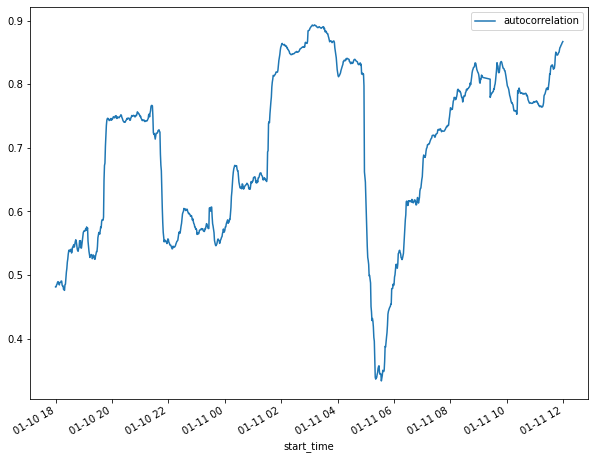

In [77]:
rolling_autocorrelation(PC_0192_residuals_no_anomalies, 120)

In [78]:
def graph_grid(f, data, a, b, c, d, type_of_func):
    """
    Inputs:
    f: function i.e rolling_mean or rolling_variance
    data: 
    a, b, c, d: 4 options for length of time windows in minutes
    type_of_funct = mean, var or ac
    units = 
    """

    time = [a, b, c, d]

    if type_of_func == 'mean':
        y_lab = "Mean (BPM)"
        typ = "mean"
    if type_of_func == 'variance':
        y_lab = "Variance (BPM^2)"
        typ = "variance"
    if type_of_func == 'autocorrelation':
        y_lab = "Autocorrelation"
        typ = "autocorrelation"

    mean_df_list = []
    rolling_mean(data, time[0])
    mean_df_list.append(df)
    rolling_mean(data, time[1])
    mean_df_list.append(df)
    rolling_mean(data, time[2])
    mean_df_list.append(df)
    rolling_mean(data, time[3])
    mean_df_list.append(df)

    var_df_list = []
    rolling_variance(data, time[0])
    var_df_list.append(df)
    rolling_variance(data, time[1])
    var_df_list.append(df)
    rolling_variance(data, time[2])
    var_df_list.append(df)
    rolling_variance(data, time[3])
    var_df_list.append(df)

    ac_df_list = []
    rolling_autocorrelation(data, time[0])
    ac_df_list.append(df)
    rolling_autocorrelation(data, time[1])
    ac_df_list.append(df)
    rolling_autocorrelation(data, time[2])
    ac_df_list.append(df)
    rolling_autocorrelation(data, time[3])
    ac_df_list.append(df)

    # fig, axs = plt.subplots(2, 2, figsize=(20,16))
    
    # axs[0, 0].plot(df['start_time'], df[typ])
    # axs[0, 0].set_title('30 minutes')

    # f(data, time[1])
    # axs[0, 1].plot(df['start_time'], df[typ], 'tab:orange')
    # axs[0, 1].set_title('60 minutes')

    # f(data, time[2])
    # axs[1, 0].plot(df['start_time'], df[typ], 'tab:green')
    # axs[1, 0].set_title('90 minutes')

    # f(data, time[3])
    # axs[1, 1].plot(df['start_time'], df[typ], 'tab:red')
    # axs[1, 1].set_title('120 minutes')

    fig, axs = plt.subplots(1, 3, figsize=(32,8), sharex=True,sharey=False)

    plt.rcParams['font.size'] = '16'
    fig.autofmt_xdate()

    # axs[0, 0].cla()
    axs[0].plot(mean_df_list[0]['start_time'], mean_df_list[0]['mean'], 'tab:blue', label="30 minutes")
    # f(data, time[1])
    axs[0].plot(mean_df_list[1]['start_time'], mean_df_list[1]['mean'], 'tab:orange', label="60 minutes")
    # f(data, time[2])
    axs[0].plot(mean_df_list[2]['start_time'], mean_df_list[2]['mean'], 'tab:green', label="90 minutes")
    # f(data, time[3])
    axs[0].plot(mean_df_list[3]['start_time'], mean_df_list[3]['mean'], 'tab:red', label="120 minutes")
    axs[0].legend()
    axs[0].set(xlabel='Time (day-month hour)', ylabel=y_lab)
    axs[0].set_title("Mean", fontsize=37)

    axs[1].plot(var_df_list[0]['start_time'], var_df_list[0]['variance'], 'tab:blue', label="30 minutes")
    # f(data, time[1])
    axs[1].plot(var_df_list[1]['start_time'], var_df_list[1]['variance'], 'tab:orange', label="60 minutes")
    # f(data, time[2])
    axs[1].plot(var_df_list[2]['start_time'], var_df_list[2]['variance'], 'tab:green', label="90 minutes")
    # f(data, time[3])
    axs[1].plot(var_df_list[3]['start_time'], var_df_list[3]['variance'], 'tab:red', label="120 minutes")
    # axs[1].legend()
    axs[1].set(xlabel='Time (day-month hour)', ylabel="Variance (BPM^2)")
    axs[1].set_title("Variance", fontsize=37)

    axs[2].plot(ac_df_list[0]['start_time'], ac_df_list[0]['autocorrelation'], 'tab:blue', label="30 minutes")
    # f(data, time[1])
    axs[2].plot(ac_df_list[1]['start_time'], ac_df_list[1]['autocorrelation'], 'tab:orange', label="60 minutes")
    # f(data, time[2])
    axs[2].plot(ac_df_list[2]['start_time'], ac_df_list[2]['autocorrelation'], 'tab:green', label="90 minutes")
    # f(data, time[3])
    axs[2].plot(ac_df_list[3]['start_time'], ac_df_list[3]['autocorrelation'], 'tab:red', label="120 minutes")
    # axs[2].legend()
    axs[2].set(xlabel='Time (day-month hour)', ylabel="Autocorrelation")
    axs[2].set_title("Autocorrelation", fontsize=37)


    # for ax in axs.flat:
    # plt.set(xlabel='Time (day-month hour)', ylabel=y_lab)
    
        

The kendall tau correlation coefficient of the autocorrelation is -0.0766455181999461, and the p-value is 8.675801327701271e-05.
The Hamid and Rao correction relusts in a p-value of 6.661338147750939e-16
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=6.661338147750939e-16, z=-8.090948159058819, Tau=-0.07674321686297735, s=-52482.0, var_s=42073182.712627836, slope=-0.00010993434906478383, intercept=0.5523742225336324)
The kendall tau correlation coefficient of the autocorrelation is -0.20032542486803392, and the p-value is 4.210595378613826e-24.
The Hamid and Rao correction relusts in a p-value of 1.1088664812142213e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=1.1088664812142213e-05, z=-4.394776760690808, Tau=-0.20014632718759146, s=-129941.0, var_s=874202584.6944857, slope=-0.00014308382554954096, intercept=0.5698582700329912)
The kendall tau correlation coeff

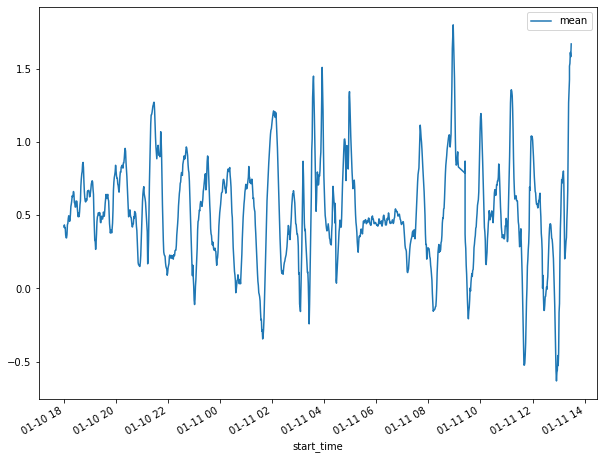

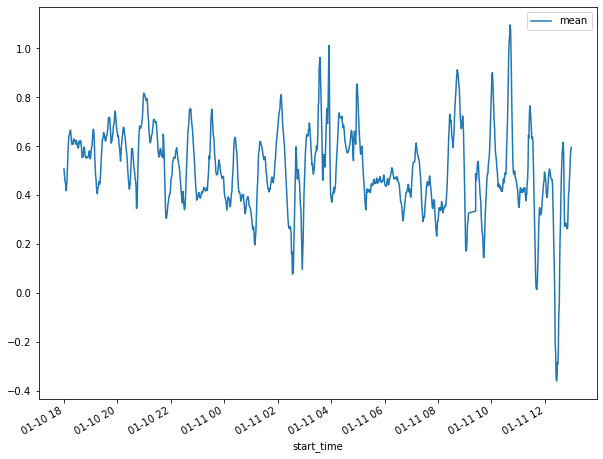

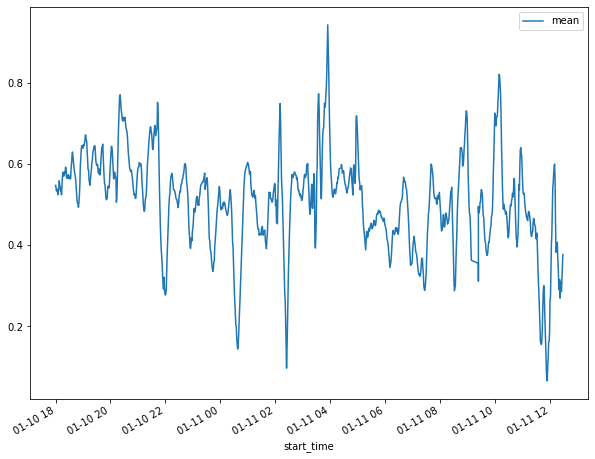

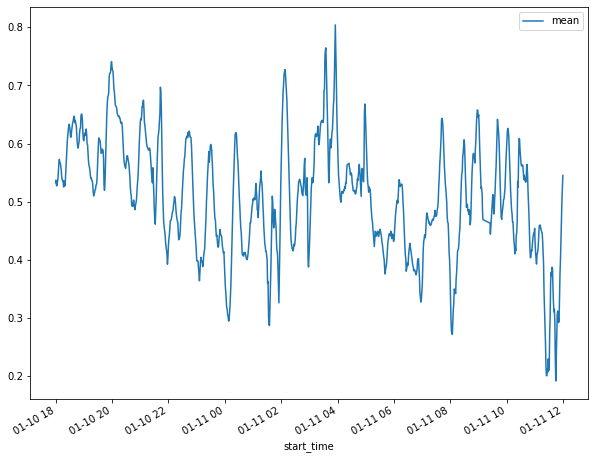

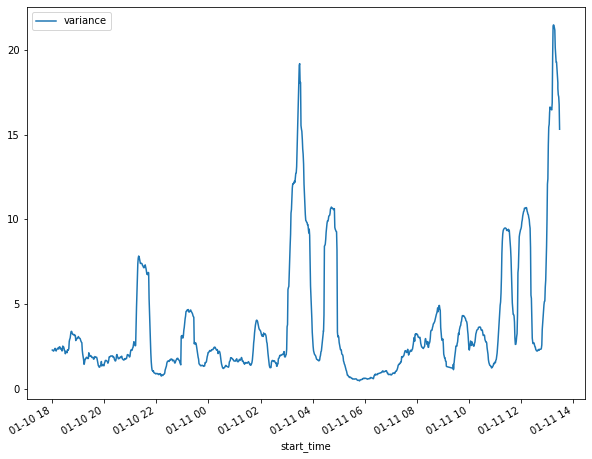

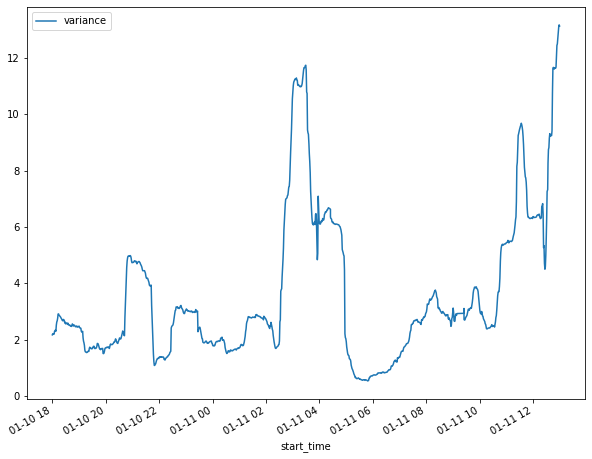

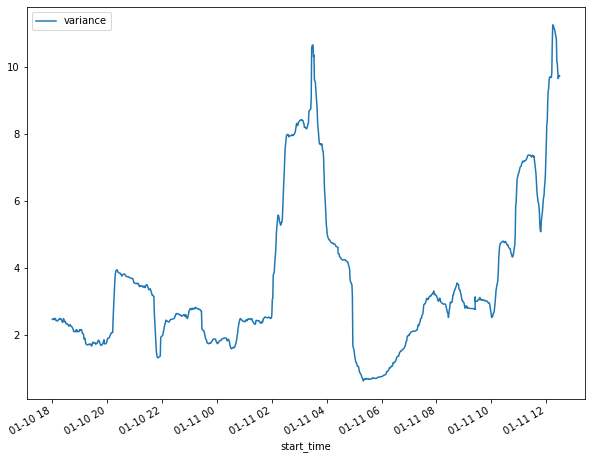

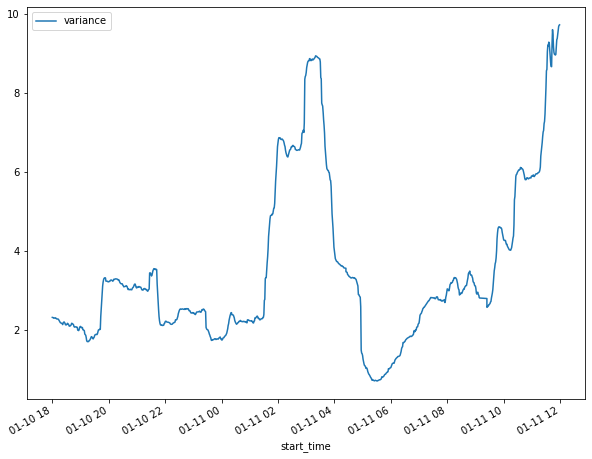

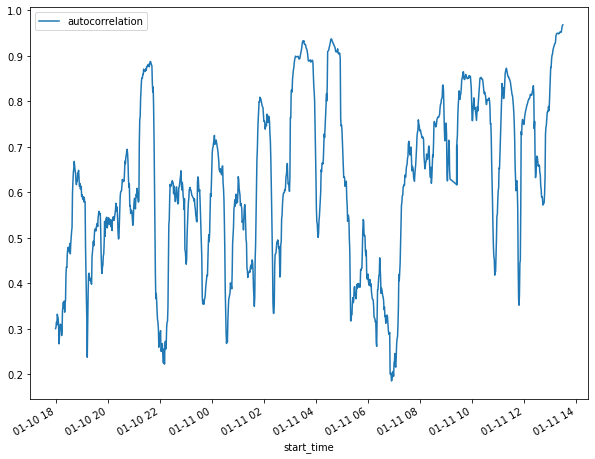

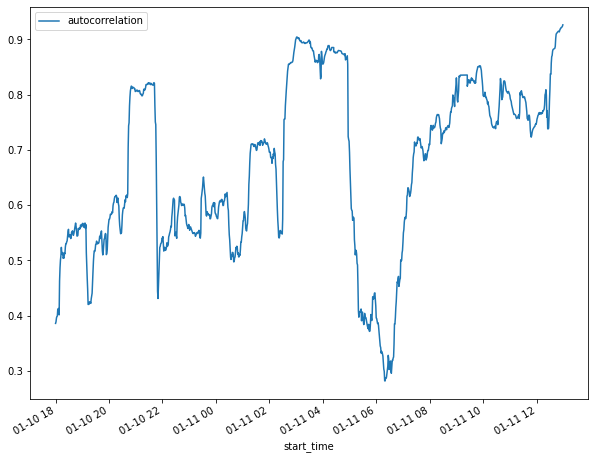

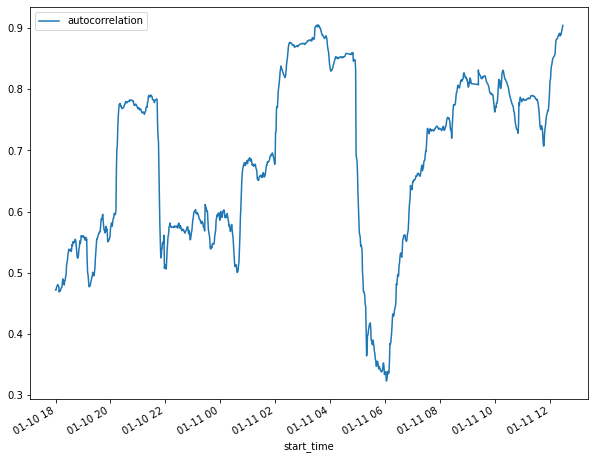

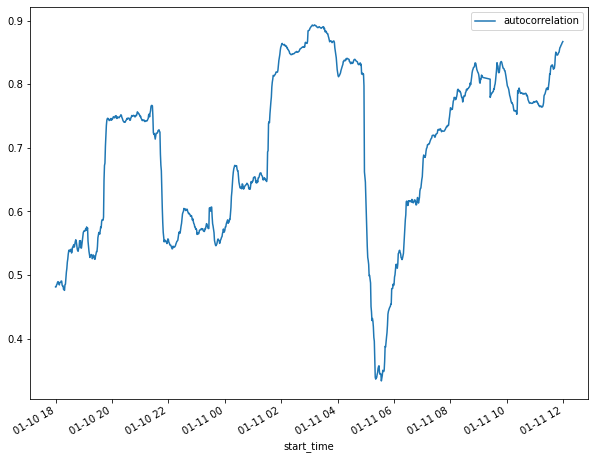

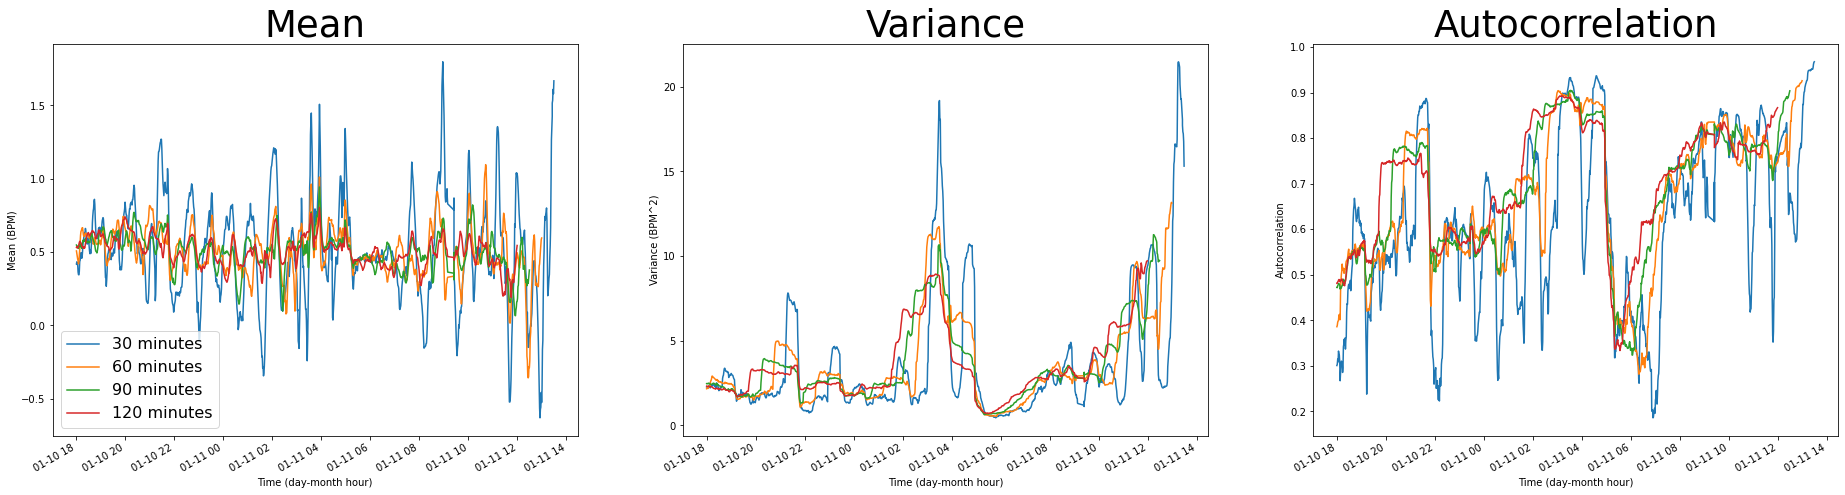

In [79]:
graph_grid(rolling_mean, PC_0192_residuals_no_anomalies, 30, 60, 90, 120, "mean")

The kendall tau correlation coefficient of the variance is 0.2400592232357987, and the p-value is 1.7614634700354948e-33.
The Hamid and Rao correction relusts in a p-value of 0.0250323996440609
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0250323996440609, z=2.240902370965912, Tau=0.2401439304072756, s=151831.0, var_s=4590598514.784497, slope=0.001842414043291688, intercept=1.6337315192632036)


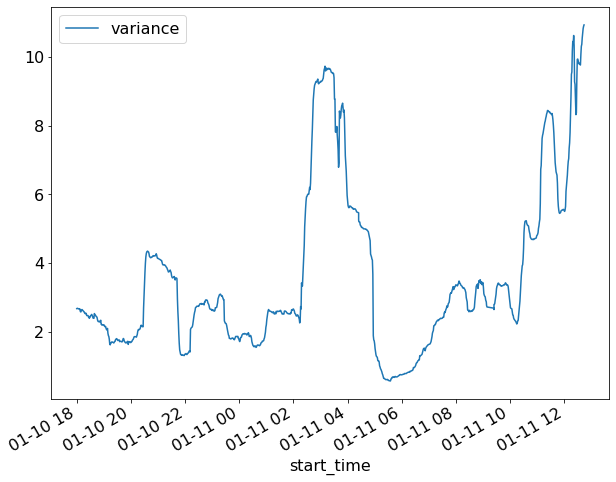

In [80]:
rolling_variance(PC_0192_residuals_no_anomalies, 75)

The kendall tau correlation coefficient of the autocorrelation is 0.3172838535211199, and the p-value is 5.868625423054345e-55.
The Hamid and Rao correction relusts in a p-value of 0.0010411659590177091
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0010411659590177091, z=3.279159975263558, Tau=0.317066556825593, s=184742.0, var_s=3173959430.9946313, slope=0.0002278530992805402, intercept=0.6180503464284836)


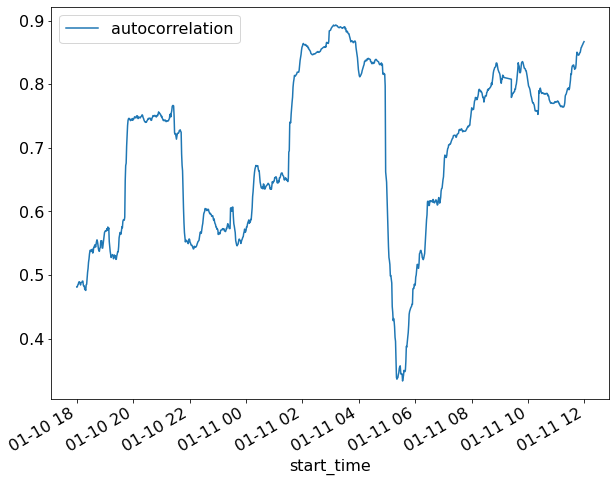

In [101]:
rolling_autocorrelation(PC_0192_residuals_no_anomalies, 120)

In [136]:
def graph_grid2(data, t, p_of_mean = False):
    """
    Inputs:

    """
    global p_list

    # time = [a, b, c, d]

    # if type_of_func == 'mean':
    #     y_lab = "Mean (BPM)"
    #     typ = "mean"
    # if type_of_func == 'variance':
    #     y_lab = "Variance (BPM^2)"
    #     typ = "variance"
    # if type_of_func == 'autocorrelation':
    #     y_lab = "Autocorrelation"
    #     typ = "autocorrelation"

    p_list = []
    rolling_mean(PC_0192_extubated, t)
    mean_df = df
    if p_of_mean:
        p_list.append(p)

    rolling_variance(data, t)
    var_df = df
    p_list.append(p)

    rolling_autocorrelation(data, t)
    ac_df = df
    p_list.append(p)

    fig, axs = plt.subplots(3, 1, figsize=(12, 24), sharex=False,sharey=False)

    plt.rcParams['font.size'] = '30'
    fig.autofmt_xdate()

    axs[0].plot(mean_df['start_time'], mean_df['mean'], 'tab:orange')
    axs[0].set(xlabel='Time (day-month hour)', ylabel="Mean, $\mu$ (BPM)")
    axs[0].set_title("Heart Rate (beats per minute)", fontsize=30)

    axs[1].plot(var_df['start_time'], var_df['variance'], 'tab:green', label=f"p={round(p_list[0],3)}")
    axs[1].legend()
    axs[1].set(xlabel='Time (day-month hour)', ylabel="Variance, $\sigma^2$ (BPM$^2$)")

    axs[2].plot(ac_df['start_time'], ac_df['autocorrelation'], 'tab:red', label=f"p={round(p_list[1],3)}")
    axs[2].legend()
    axs[2].set(xlabel='Time (day-month hour)', ylabel="Autocorrelation, $r_1$", ylim=([-1, 1]), font_size = '30')


    # axs[2].ylim([0, 1])

The kendall tau correlation coefficient of the autocorrelation is 0.5882327571656905, and the p-value is 2.2115081503212766e-194.
The Hamid and Rao correction relusts in a p-value of 1.1355461881912277e-07
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=1.1355461881912277e-07, z=5.303578051023711, Tau=0.5883076875683502, s=381947.0, var_s=5186399934.470368, slope=0.012852869136205694, intercept=92.96620276217513)
The kendall tau correlation coefficient of the variance is 0.23883753811021646, and the p-value is 1.404965346688036e-33.
The Hamid and Rao correction relusts in a p-value of 0.023801693774995414
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.023801693774995414, z=2.2603152241601383, Tau=0.23871663355051367, s=154982.0, var_s=4701310087.939496, slope=0.0018148216347970833, intercept=1.7227545960595634)
The kendall tau correlation coefficient of the autocor

AttributeError: 'AxesSubplot' object has no property 'font_size'

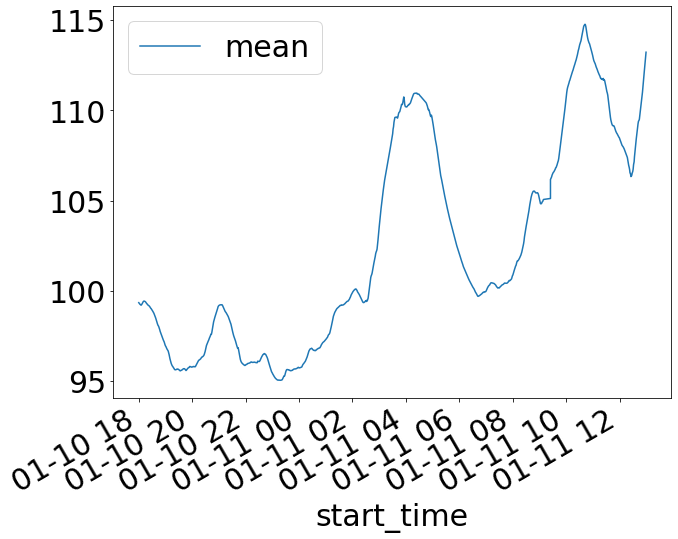

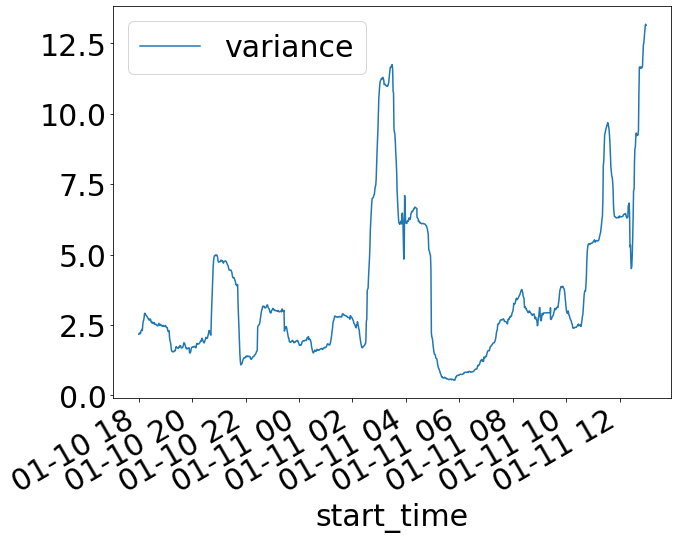

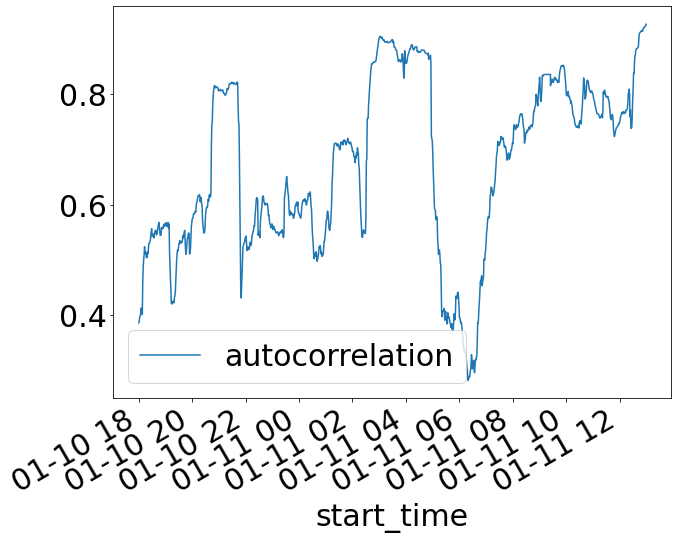

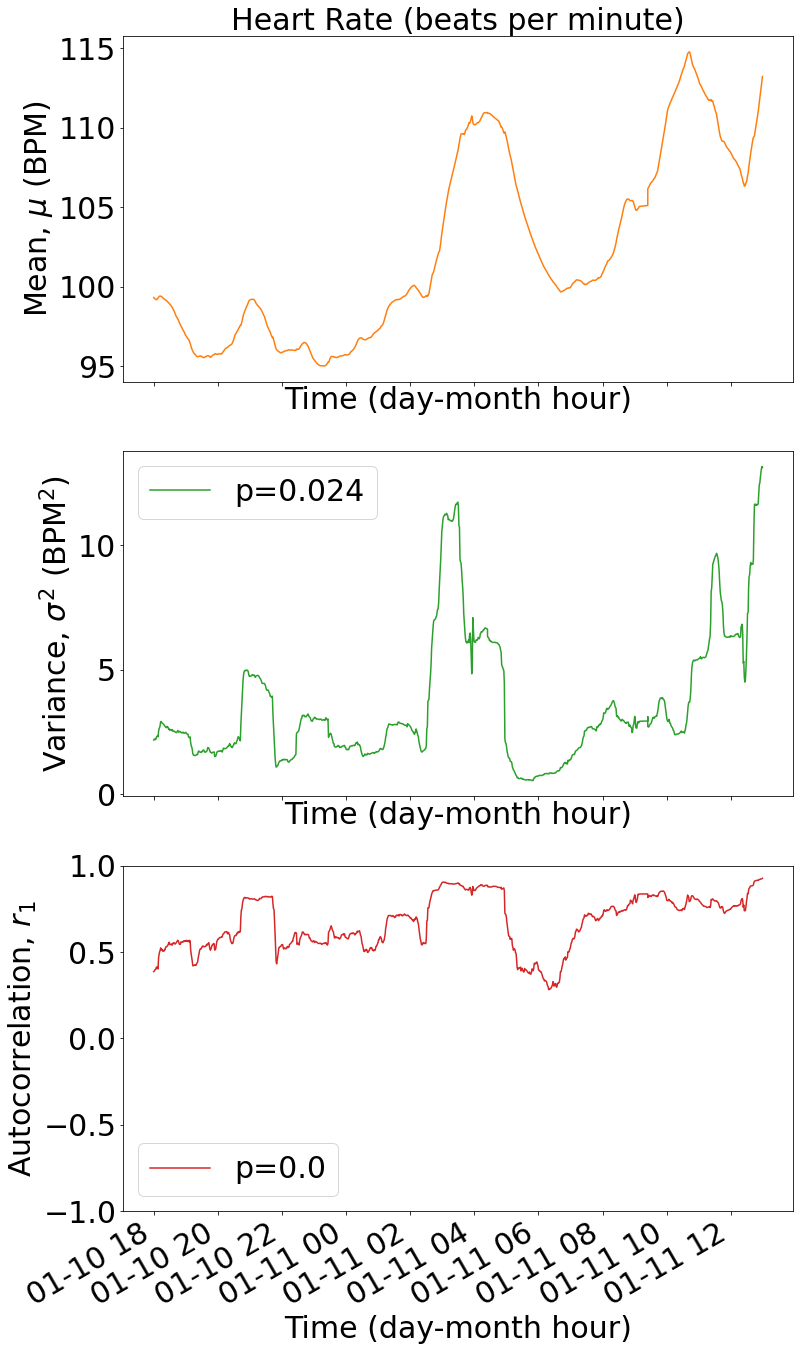

In [137]:
graph_grid2(PC_0192_residuals_no_anomalies, 60)